In [2]:
# I have preprocessed scans of files in folder named as AP6H6G(as given by you) in this.


import numpy as np
import pydicom as pyd
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 


In [6]:
data_path='./10-24-2014-CT CHEST SCREENING-42297/2-Body 2.0 WITHOUT-43579'
output_path='../Project/GIT/data-analysis-diwali'


In [12]:
# this function is fixing the missing values (if any) in the Slice Thickness Metadata
def load_scan(path):#We can also do it for the other code, do it later.
    # replace it with os.walk
    slices=[pyd.dcmread(path+'/'+s) for s in os.listdir(path)]#List comprehension
    #Sort the list by Instance number, instance is a unique key in each of the DICOM file
    slices.sort(key=lambda x: int(x.InstanceNumber)) 
    try:#Slice thickness is along z axis, but we dont know actual coordinates because of reference issues, so 
        #we define slice_thickness as difference.
        silce_thickness=np.abs(slices[0].ImagePositionPatient[2]-slices[1].ImagePositionPatient[2])
    except:
        slice_thickness=np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

        
        # Slice location and image position [2] are same, this error handler ensures that if there is a missing value in image position, it takes slice location    for s in slices:#For every slice it will set the attribute to the value of above array
        s.SliceThickness=slice_thickness
    return slices

    
def get_pixels_hu(scans):
    image=np.stack(list(ds.pixel_array for ds in scans))#We have stacked all the arrays(pixel arrays) as one. 
    image=image.astype(np.int16)#Image is the' combined effect' of slices' pixels data
    intercept=scans[0].RescaleIntercept# These two attributes are already present in ds(ResInter and Slope)
    slope=scans[0].RescaleSlope
    image[image == -2000] = 0 #
    if slope !=1:#slope is assumed to be one generally
        image = slope * image.astype(np.float64)
        image=image.astype(np.int16)
    image=image+np.int16(intercept) #Formula for hu conversion: slope*image+intercept
    return np.array(image, dtype=np.int16)
id=0    


In [15]:
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)# for the second function patient is scans
# It should be noted that imgs contain pixel data and array used.
imgs.shape#This contains the actual data archive
patient[0]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.5438.5601.219658707797765365844942754235
(0008, 0020) Study Date                          DA: '20141024'
(0008, 0023) Content Date                        DA: '20141024'
(0008, 0030) Study Time                          TM: '073658.000'
(0008, 0033) Content Time                        TM: '073905.982'
(0008, 0050) Accession Number                    SH: '3689325351414468'
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) Manufacturer                        LO: 'TOSHIBA'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 1030) Study Description                   LO: 'CT CHEST SCREENING'
(0008, 103e) Series Description                  LO: 'Body 2.0 WITHOUT'
(0008

In [6]:
# print(patient)

In [9]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [10]:
normalize(imgs)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [17]:
dc=patient[0]
# print(imgs)
#This has loaded all the arrays within the pixel array
# We'll have a 2d visualisation of the data provided.
ConstPixelSpacing=(float(dc.PixelSpacing[0]),float(dc.PixelSpacing[1]),float(dc.SliceThickness))
#  PixelSpacing and SliceThickness attributes to calculate the spacing between pixels in the three axes.
#Argument1:alongx-axis,arg2:along-y axis spacing,arg3:The slice thickness along z axis

In [19]:
ConstPixelDims=(int(dc.Rows),int(dc.Columns),int(len(patient)))
# We are storing dimensions in this (Number of pixel rows in a slice) x (
# Number of pixel columns in a slice) x (Number of slices) 

In [20]:
# Creating an array for x, y, and z axis respectively for storing the actual
x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
# The third argument makes division of pixels

In [21]:
# On the basis of dimensions stored, we can now create an array like this
ArrayDCM=np.zeros(ConstPixelDims,dtype=dc.pixel_array.dtype)#Here pixel_array is a property of pydicom used
# as a method. We are deriving the required data type from it. In this case int16. 
# pixel_array object is a pure np array containing the pixel-data for the particular DICOM slice


print(ArrayDCM[1:3])

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [29]:
# To get 2d visualization 
slices=[(data_path+'/'+s) for s in os.listdir(data_path)]
for filenameDCM in slices:
    # read the file
    dc1 = pyd.dcmread(filenameDCM)
    # store the raw image data
    ArrayDCM[:, :, slices.index(filenameDCM)] = dc1.pixel_array  

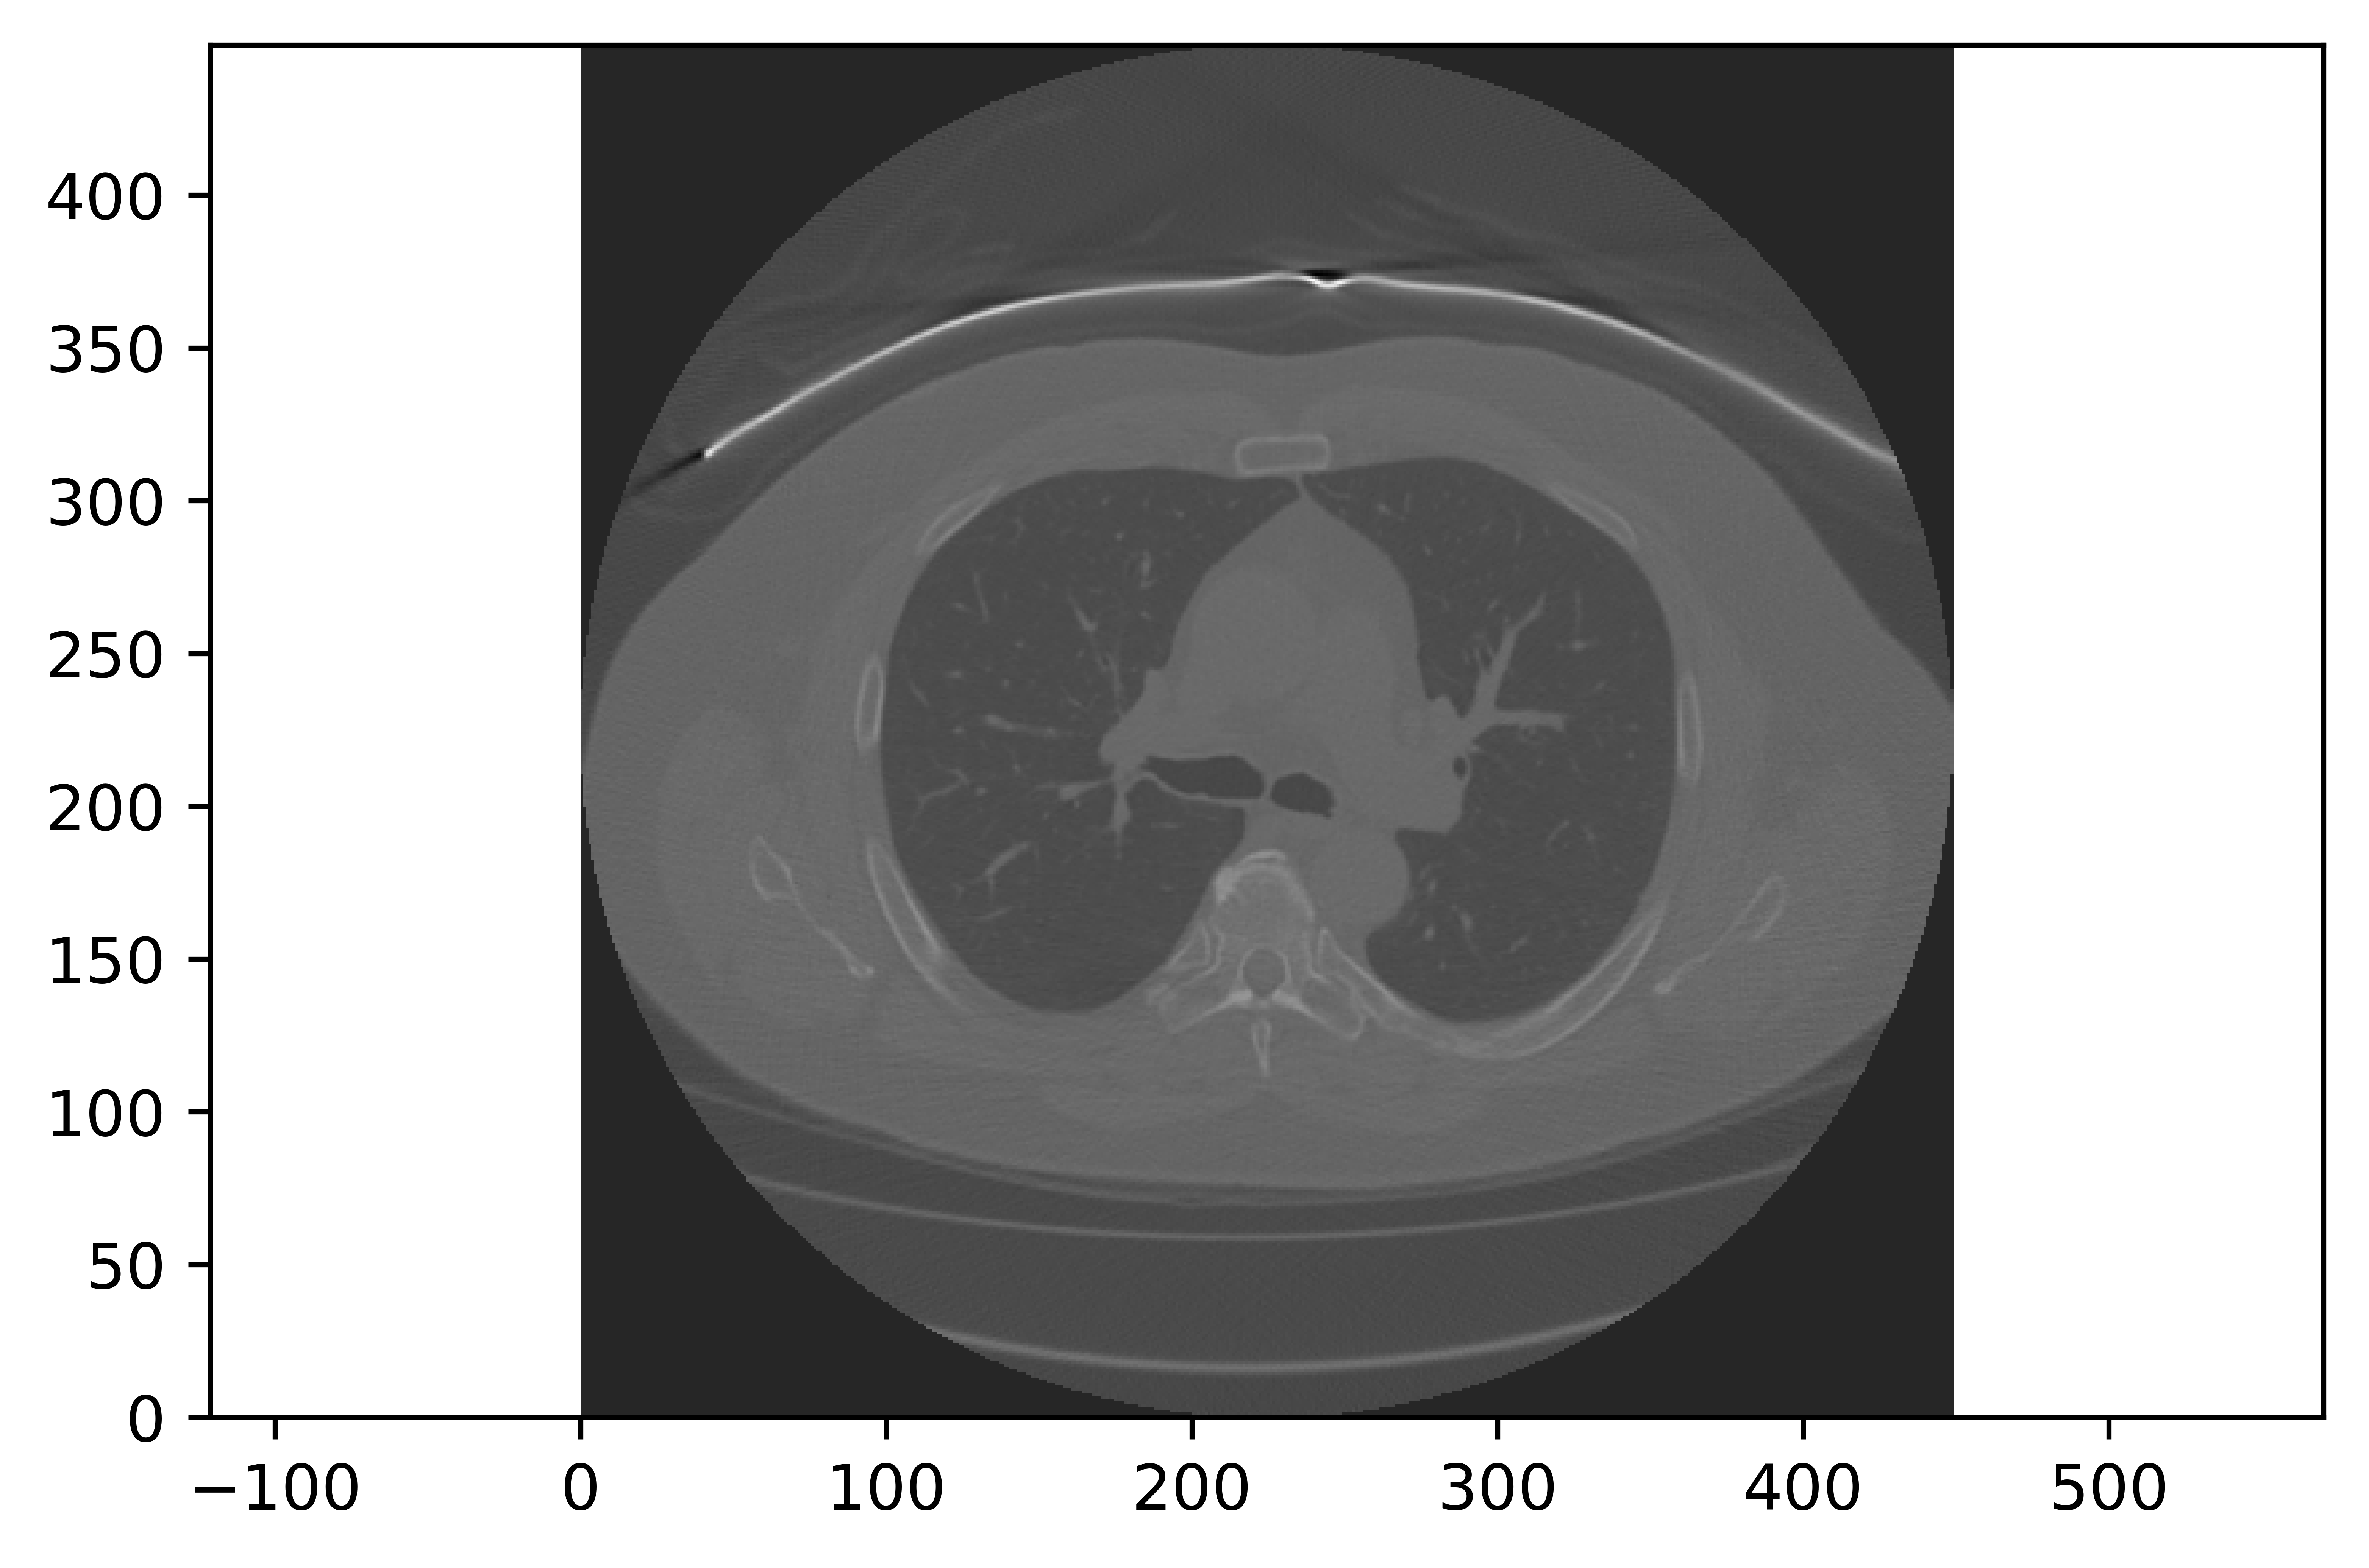

In [31]:
plt.figure(dpi=1200)
plt.axes().set_aspect('equal', 'datalim')
plt.set_cmap(plt.gray())
plt.pcolormesh(x, y, np.flipud(ArrayDCM[:, :, 127]))
plt.show()

In [32]:
output_path='../Project/GIT/data-analysis-diwali'

In [33]:
np.save(os.path.join(output_path,'/PROJECTIMGS_%d.npy'%(id)),imgs)

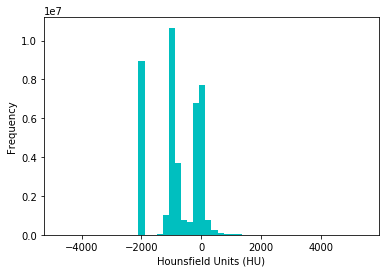

In [34]:
#Let's see graphically the statistics of bones and fires :p :
files_saved=(np.load(os.path.join(output_path,'/PROJECTIMGS_%d.npy'%(id))))
imgs_plot=files_saved.astype(np.float64)
plt.hist(imgs_plot.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [13]:
print(patient[0].PixelSpacing[0])


0.9765625


In [14]:
# printing out some parameters:
print('Pixel spacing(row,col):(%f,%f)'%(patient[0].PixelSpacing[0],patient[0].PixelSpacing[1]))
print('Slice Thickness: %f'%(patient[0].SliceThickness))
# we have rows=512, columns=512 so each represent approx 496 mm of length.
# each slice represents approximately 496 mm of data in length and width.
# if we scanned an 85-pound patient at the same “zoom” as a 190-pound patient, you wouldn’t want the scan 
# to occupy only the middle 250 voxels with a wide rim of air – you’d want to zoom in at the time of
# acquisition so that it makes a full use of the 512 x 512. This means that each CT scan actually 
# represents different dimensions in real life even though they are all 512 x 512 x Z slices.
print(patient[0].SliceThickness)
print((patient[0].PixelSpacing))

Pixel spacing(row,col):(0.976562,0.976562)
Slice Thickness: 3.000000
3
['0.9765625', '0.9765625']


In [35]:
# An isometric transformation is one where the distance between any two pixels in A, and the distance between the 
# equivalent two pixels in B does not change after the transformation has been applied
# There is always zoom/slice thickness invariance. A slice might have [2.4,3,3] as pixel spacing coordinates for one
# scan and for other it might be different. So we need to resample data by setting Pixel Spacing as [1,1,1]
id = 0

def resample(imgs_rsmpl,scan,set_spacing=[1,1,1]):
    # Determine current pixel spacing
    
    spacing = list(map(float,list([scan[0].SliceThickness])+list(scan[0].PixelSpacing)))#We are adding two
#   lists here. The final concatenated list contain spacing as this order: z,x,y,(,slices,rows,col)
    print(spacing) 
    spacing = np.array(spacing)#To make an array 
    print(imgs_rsmpl.shape)
    resize_factor = spacing / set_spacing   #
    new_real_shape = imgs_rsmpl.shape * resize_factor    
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / imgs_rsmpl.shape
    set_spacing = spacing / real_resize_factor
    print(set_spacing)
    
    imgs_rsmpl = scipy.ndimage.interpolation.zoom(imgs_rsmpl, real_resize_factor)
    
    return imgs_rsmpl, set_spacing

print ("Shape beforeresampling\t", files_saved.shape)
imgs_after_resamp, spacing = resample(files_saved, patient, [1,1,1])
print ("Shape after resampling\t", imgs_after_resamp.shape)
# Various print commands are executed above to make sure what we are doing is right.:p

Shape beforeresampling	 (159, 512, 512)
[2.0, 0.877, 0.877]
(159, 512, 512)
[1.         1.00005345 1.00005345]
Shape after resampling	 (318, 449, 449)


In [36]:
def plot_3d(image, threshold=-300):
#     This is made using the marching cubes algorithm. Classic, the performance might be poor.
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    verts, faces = measure.marching_cubes_classic(p, threshold)
#     verts, faces = measure.marching_cubes_lewiner(p, level=None, spacing=(1.0, 1.0, 1.0))

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [ ]:
plot_3d(imgs_after_resamp,400)

In [ ]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

In [ ]:
img = imgs_after_resamp[260]
make_lungmask(img, display=True)

In [ ]:
masked_lung = []
for img in imgs_after_resamp:
    masked_lung.append(make_lungmask(img))